In [32]:
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),1*Matern()+1*WhiteKernel(noise_level=0.5)]


dataDir = Path.cwd().parent.parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"ts_dataset_58_with_cat.csv", index_col="id")

In [33]:
X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=10)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

Mean cross-validated score of the best_estimator:  0.9883040935672516
Best estimator parameters:  {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.890 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.977 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.988 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.977 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.988 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


d:\Toolbox\python\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
#best_kernel = 1*DotProduct()
best_kernel = 1*Matern()

model_ini = GaussianProcessClassifier(kernel=best_kernel, random_state=10, n_jobs=-1, optimizer=None)
model_ini.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model_ini.score(X_train, y_train))

model_opt = GaussianProcessClassifier(kernel=best_kernel, random_state=8, n_jobs=-1)
model_opt.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model_opt.score(X_train, y_train))


print(
    "Log Marginal Likelihood: %.3f"
    % model_ini.log_marginal_likelihood(model_ini.kernel_.theta)
)
print(
    "Log Marginal Likelihood: %.3f"
    % model_opt.log_marginal_likelihood(model_opt.kernel_.theta)
)

print(
    "Log-loss: %.3f (initial) %.3f (optimized)"
    % (
        log_loss(y_train, model_ini.predict_proba(X_train)[:, 1]),
        log_loss(y_train, model_opt.predict_proba(X_train)[:, 1]),
    )
)

model_opt.predict_proba


Mean accuracy on training data:  1.0
Mean accuracy on training data:  1.0
Log Marginal Likelihood: -30.127
Log Marginal Likelihood: -14.503
Log-loss: 0.537 (initial) 0.212 (optimized)


<bound method GaussianProcessClassifier.predict_proba of GaussianProcessClassifier(kernel=1**2 * Matern(length_scale=1, nu=1.5),
                          n_jobs=-1, random_state=8)>

[Text(0.5, 1.0, 'GPC-Matern-Train'),
 Text(0.5, 0, 'Predicted probability(positive class)'),
 Text(0, 0.5, 'Count')]

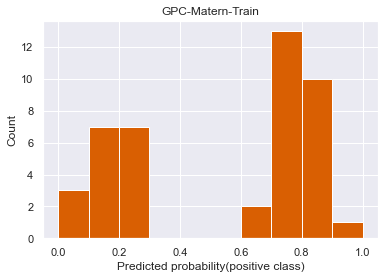

In [5]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
colors = plt.cm.get_cmap("Dark2")

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(
    model_opt.predict_proba(X_train)[:,1],
    range=(0, 1),
    bins=10,
    label="GP",
    color=colors(1),
    )
ax.set(title="GPC-Matern-Train", xlabel="Predicted probability(positive class)", ylabel="Count")

In [5]:
model_opt.predict_proba(X_train)[:,0]

array([0.12090796, 0.21627694, 0.78164425, 0.74937429, 0.21795157,
       0.14779879, 0.20718099, 0.22573583, 0.85540361, 0.20786088,
       0.9197243 , 0.08143342, 0.20731158, 0.21571631, 0.35301537,
       0.21864572, 0.84569234, 0.77003951, 0.82103658, 0.26220004,
       0.17990121, 0.17948935, 0.91968395, 0.10910765, 0.26175509,
       0.14502649, 0.15151372, 0.24390474, 0.17583272, 0.91070355,
       0.78806   , 0.89161424, 0.76139138, 0.83333867, 0.84666041,
       0.78815821, 0.13715649, 0.79505181, 0.21423684, 0.2865938 ,
       0.1474656 , 0.84360509, 0.3075417 ])

In [6]:
#best_kernel = 1*DotProduct()
best_kernel = 1*Matern()
model = GaussianProcessClassifier(kernel=best_kernel, random_state=8, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  1.0
Prediction on test data:  [1 1 0 1 1 1 1 1 1 1 0 0 1 0 1]
Prediction accuracy on test data:  1.0


In [7]:
X_test

,"MilkProduction__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","MilkProduction__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","MilkProduction__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","MilkProduction__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""mean""","MilkProduction__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","MilkProduction__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""",MilkProduction__ratio_value_number_to_time_series_length,MilkProduction__percentage_of_reoccurring_values_to_all_values,MilkProduction__percentage_of_reoccurring_datapoints_to_all_datapoints,"MilkProduction__linear_trend__attr_""stderr""",...,"timeDelta_Seconds__fft_coefficient__attr_""abs""__coeff_29","timeDelta_Seconds__fft_coefficient__attr_""abs""__coeff_47","timeDelta_Seconds__fft_coefficient__attr_""abs""__coeff_91","timeDelta_Seconds__fft_coefficient__attr_""abs""__coeff_77","timeDelta_Seconds__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","timeDelta_Seconds__fft_coefficient__attr_""abs""__coeff_42",BreedName_1,BreedName_2,BreedName_4,BreedName_99
id,,,,,,,,,,,,,,,,,,,,,
32,-0.151619,-0.144962,-0.137450,0.210548,-0.138150,-0.153087,0.244038,-0.289260,-0.183533,-0.147778,...,-0.821870,1.066541,-0.035166,0.218637,0.205231,-0.573671,0.0,1.0,0.0,0.0
4,0.051116,0.019061,0.099010,2.195154,0.119947,0.123496,1.573510,-1.369383,-1.605917,0.020344,...,2.489467,0.113390,3.049615,-0.365618,0.917432,3.511642,0.0,1.0,0.0,0.0
38,-0.188569,-0.182294,-0.187764,-0.353082,-0.647360,-0.197584,-0.494440,0.432039,0.542632,-0.189645,...,-0.811775,-0.947682,-0.725042,-0.710123,-0.034718,-0.966955,1.0,0.0,0.0,0.0
28,-0.198404,-0.186765,-0.190078,-0.373356,-1.181010,-0.202357,-0.881564,0.680685,0.818511,-0.189579,...,-0.226762,1.903076,-0.968036,1.058242,-0.468090,-0.206714,0.0,1.0,0.0,0.0
22,-0.121605,-0.116988,-0.042149,0.970661,-0.071398,-0.033702,1.116915,-1.087716,-1.145006,-0.034654,...,-0.907015,-0.193202,-0.722033,-0.221175,-0.445084,-0.348005,1.0,0.0,0.0,0.0
18,-0.159678,-0.164364,-0.176976,-0.483068,0.003228,-0.172686,0.130227,0.044057,0.063793,-0.158596,...,0.354470,-0.332398,0.306971,-0.547007,-0.774946,-0.656003,0.0,1.0,0.0,0.0
46,-0.111642,-0.127065,-0.138961,-0.180841,-0.023027,-0.124563,0.445038,-0.515383,-0.418128,-0.123229,...,-0.239027,-0.236768,-0.311936,0.243869,-0.197787,0.256923,0.0,0.0,1.0,0.0
3,0.044065,0.029976,0.032930,1.593552,1.680422,0.028293,1.177995,-1.048847,-1.152757,-0.033038,...,2.312307,1.981199,-0.286557,0.053157,1.323299,-0.122541,0.0,1.0,0.0,0.0
24,-0.050134,-0.069358,-0.056235,0.587010,2.306600,-0.057163,1.319163,-1.260077,-1.379195,-0.068774,...,3.066573,1.711135,-0.719854,1.612584,0.960392,0.409609,1.0,0.0,0.0,0.0


In [8]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.14069001, 0.85930999],
       [0.20829313, 0.79170687],
       [0.5866263 , 0.4133737 ],
       [0.4752918 , 0.5247082 ],
       [0.28963218, 0.71036782],
       [0.17827066, 0.82172934],
       [0.2025179 , 0.7974821 ],
       [0.15667253, 0.84332747],
       [0.12335449, 0.87664551],
       [0.1373424 , 0.8626576 ],
       [0.75141791, 0.24858209],
       [0.93980368, 0.06019632],
       [0.34514434, 0.65485566],
       [0.64332464, 0.35667536],
       [0.24495825, 0.75504175]])

In [23]:
cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)
cow_id

Index(['32', '4', '38', '28', '22', '18', '46', '3', '24', '27', '36', '39',
       '21', '44', '8'],
      dtype='object', name='id')

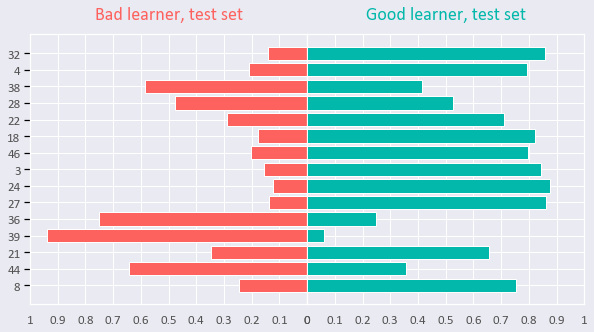

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Bad learner, test set'
title1 = 'Good learner, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'good&bad_learner'
plt.savefig(filename+'.png', facecolor=facecolor)

[Text(0.5, 1.0, 'GPC-Matern-Test'),
 Text(0.5, 0, 'Predicted probability(positive class)'),
 Text(0, 0.5, 'Count')]

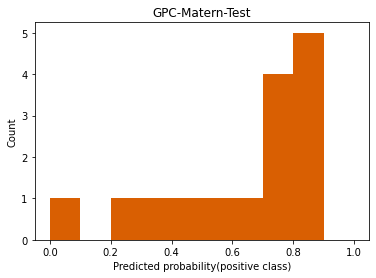

In [41]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
colors = plt.cm.get_cmap("Dark2")

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(
    model.predict_proba(X_test)[:,1],
    range=(0, 1),
    bins=10,
    label="GP",
    color=colors(1),
    )
ax.set(title="GPC-Matern-Test", xlabel="Predicted probability(positive class)", ylabel="Count")

In [36]:
ts_dataset

,"timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2",...,timeDelta_Seconds__quantile__q_0.8,timeDelta_Seconds__quantile__q_0.7,"timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",timeDelta_Seconds__mean_abs_change,"timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",timeDelta_Seconds__mean,BreedName_1,BreedName_2,BreedName_4,label
id,,,,,,,,,,,,,,,,,,,,,
1,-0.892543,-1.967178,-1.864354,-2.005686,-0.939033,-1.813592,-1.294771,-1.111943,-1.158618,-1.073848,...,-1.095250,-1.056712,-1.224945,-1.967178,-1.034363,-0.982661,1.0,0.0,0.0,0
2,-0.368274,-0.095543,-0.333365,-0.040805,-0.412923,-0.552221,-0.274979,-0.532136,-0.775876,-0.425686,...,-0.511132,-0.626362,-0.387532,-0.095543,-0.413100,-0.559507,0.0,1.0,0.0,0
3,0.474841,1.281555,0.592292,0.280721,0.538522,1.111727,0.257960,0.834284,1.095254,0.498651,...,1.299679,1.395223,0.536108,1.281555,0.393414,1.787649,1.0,0.0,0.0,1
4,0.709707,1.195803,1.005099,0.994186,1.166862,1.683797,1.307773,1.552361,1.180452,0.945346,...,1.701406,1.782827,1.770966,1.195803,0.795727,1.766106,0.0,0.0,1.0,1
5,-0.708845,-0.478761,-0.627179,-0.629481,-0.759835,-0.471325,-0.785756,-0.640556,-0.946368,-0.753154,...,-0.632258,-0.426453,-0.790245,-0.478761,-0.653210,-0.238047,0.0,1.0,0.0,0
6,0.234937,0.337581,0.375677,0.196194,0.094586,0.390421,0.110778,0.158206,0.391069,0.211301,...,0.413916,0.409178,0.305719,0.337581,0.189125,0.428731,0.0,1.0,0.0,1
7,-0.552449,-0.633140,-0.500709,-0.477285,-0.556826,-0.516984,-0.632304,-0.576422,-0.605416,-0.514072,...,-0.732339,-0.544406,-0.497241,-0.633140,-0.547924,-0.899945,1.0,0.0,0.0,0
8,3.304686,1.867304,2.631367,1.934144,3.095905,2.215864,2.141279,2.843172,2.472536,3.196588,...,2.083023,2.304775,2.171732,1.867304,3.273493,1.745489,0.0,1.0,0.0,1
9,-0.630273,-0.675077,-0.534787,-0.564429,-0.612738,-0.416007,-0.753608,-0.555778,-0.543829,-0.576715,...,-0.753384,-0.493946,-0.869843,-0.675077,-0.592715,-0.691563,1.0,0.0,0.0,0


In [ ]:
mean_prediction, std_prediction = model.predict(X, return_std)

In [ ]:
plt.fill_between(
    X_train, y_train.values.ravel()
    pred
)